In [8]:
import warnings

warnings.filterwarnings("ignore")

# Learning goals
After today's lesson you should be able to:
- Use cross-validation
- Find the best model for classification and regression problems based on tuning hyperparameters and calculating performance scores

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from pysal.lib import weights


## 0.1 Import the data

For this exercise, let's use the San Diego AirBnB data set again. As a reminder: This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).


Our aim here is to predict the **`log_price`** (Regression) of an AirBnB. 

In [10]:
db = gpd.read_file("https://www.dropbox.com/s/zkucu7jf1xug869/regression_db.geojson?dl=1")


In [11]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [12]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


Again, notice here that we have: 
- **Discrete variables** (number of bedrooms, beds, baths)
- **Dummy variables** (whether there is a pool, whether near the coast, room type)

# 1. `log_price`
Let's start off with predicting the price of the Airbnb. 


In [13]:
y = db['log_price']

## We'll make our X, independent variables, the "kitchen sink" of all of our other variables for now. 
## I'm using all the variables we have available with the exception of `neighborhood`, which we have to turn into dummy variables in a second. 

X = db[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'pool',
       'd2balboa', 'coastal', 'pg_Apartment',
       'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse',
       'rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room']]

## 1.1 Feature engineering
Feature engineering is the process of creating new variables from the ones you already have. Common feature engineering tasks include:
- Creating dummy variables from categorical variables
- Creating interaction terms between variables
- Creating polynomial terms from variables
- Creating log or square root terms from variables
- Creating lagged variables from time series data or lagged spatial variables 


In [14]:
neighborhood_dummies = pd.get_dummies(db['neighborhood'])

In [15]:
neighborhood_dummies.head()

,Balboa Park,Bay Ho,Bay Park,Carmel Valley,City Heights West,Clairemont Mesa,College Area,Core,Cortez Hill,Del Mar Heights,...,Park West,Rancho Bernadino,Rancho Penasquitos,Roseville,San Carlos,Scripps Ranch,Serra Mesa,South Park,University City,West University Heights
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [16]:
## Here, I want to concatenate my X and neighborhood_dummies into one dataframe.
## I need to tell pd.concat() to either add new columns (axis=1) or add new rows (axis=0).
## The default is axis=0, ie new rows, so I need to specify axis=1.
X = pd.concat([X, neighborhood_dummies],axis=1)

In [17]:
X.head()

,accommodates,bathrooms,bedrooms,beds,pool,d2balboa,coastal,pg_Apartment,pg_Condominium,pg_House,...,Park West,Rancho Bernadino,Rancho Penasquitos,Roseville,San Carlos,Scripps Ranch,Serra Mesa,South Park,University City,West University Heights
0,5,2.0,2.0,2.0,0,2.972077,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,6,1.0,2.0,4.0,0,11.501385,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.0,1.0,1.0,0,2.493893,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1.0,1.0,1.0,0,22.293757,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,1.0,1.0,1.0,0,6.829451,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


Let's also create a new column that is the KNN spatial lag for the 'neighborhood context'. Here, I'm going to use the columns: 
- `pool`, which is a binary (0,1) variable for whether the airbnb has a pool
- `pg_House` which is a binary (0,1) variable for whether the airbnb is a house

I will choose K=20, to give me the 20 closest neighboring Airbnbs. My spatial lag should be a number between 0 and 20 to estimate, of the 20 closest Airbnb, how many have pools and how many are other housees.

In [18]:
knn = weights.KNN.from_dataframe(db, k=20)

In [19]:
pool_lag = weights.lag_spatial(knn, db['pool'])
house_lag = weights.lag_spatial(knn, db['pg_House'])

Add these to new features to our original data. 

In [20]:
X['pool_lag'] = pool_lag
X['house_lag'] = house_lag


## 1.1 Create our Train-Test Split
We almost always start off with splitting our data into our **train** and **test** sets. 

In [21]:
from sklearn.model_selection import train_test_split

## Let's use the default split for now, which is 75-25 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,)


## 1.2 Predict the data
Here, let's use a decision tree regressor to predict the price. 

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Use the permutation importance function from sklearn.inspection
from sklearn.inspection import permutation_importance


In [23]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

## 1.3 Cross-validation
Now we use the k-fold cross-validation method is run our model several times on different parts of the training data. 

In [24]:
## The default scoring metric for Random Forest is R^2, so we can use cross_val_score() to get the R^2 for each fold.
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.70043575, 0.71362055, 0.69199873, 0.69875651, 0.700912  ])

As you can see, there is some variation here. 

In [25]:
scores.mean()

0.7011447092343468

## 1.4 Test score 
Let's see how well our model does on the test data. 

In [23]:
# evaluate the model on the second set of data
ypred_rf = model.predict(X_test)
print("R^2 is:", r2_score(y_test, ypred_rf))
print("Mean absolute error is:", mean_absolute_error(y_test, ypred_rf))
print("Mean squared error is:", mean_squared_error(y_test, ypred_rf))

R^2 is: 0.6919592376659811
Mean absolute error is: 0.3236937559938276
Mean squared error is: 0.1968245359608526


## 1.5 Feature Importance for the Test Set
Note: You can also estimate the importance for the training set, but generally we're interested in performance for new data (test set). 

### 1.5.1 Impurity based feature importance

In [26]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)


In [27]:
importances

array([3.58921913e-02, 1.07804990e-01, 4.52947349e-01, 1.66231032e-02,
       7.41011974e-03, 8.56416605e-02, 1.56878431e-02, 9.32224691e-03,
       4.44677078e-03, 5.01951877e-03, 1.43363385e-02, 2.23094369e-03,
       9.05598448e-02, 1.06475624e-02, 7.55299822e-03, 1.39358833e-03,
       3.33196188e-04, 4.94014580e-04, 8.61884997e-04, 1.22287867e-03,
       4.76111233e-04, 1.24703834e-03, 1.03355769e-03, 1.72085208e-03,
       9.61861875e-04, 1.92848012e-03, 2.93422795e-03, 1.50566486e-03,
       6.47888470e-04, 4.07819314e-04, 5.73435299e-03, 3.83569853e-04,
       1.45612525e-03, 3.49520965e-03, 1.18326232e-03, 2.81191278e-03,
       2.16118521e-03, 2.40414745e-03, 6.19055152e-04, 2.56669201e-03,
       1.09326490e-04, 2.52733409e-03, 9.33065076e-04, 5.94711287e-04,
       2.26602593e-03, 5.24007114e-04, 1.20155269e-03, 1.52123617e-03,
       1.91334171e-04, 2.41089994e-03, 1.21785034e-03, 9.12377378e-04,
       2.18262596e-04, 9.50986314e-04, 7.25078721e-04, 4.27020221e-04,
      

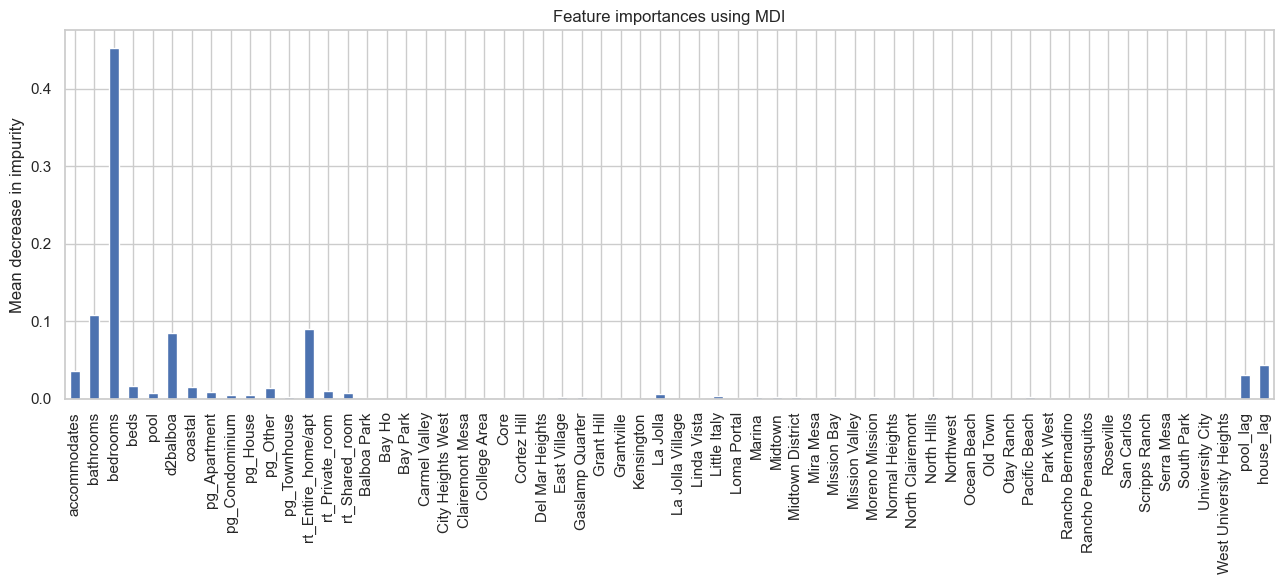

In [28]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(13,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### 1.5.2 Permutation based feature importance
This will take a few seconds because we have to reshuffle each column!

In [29]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

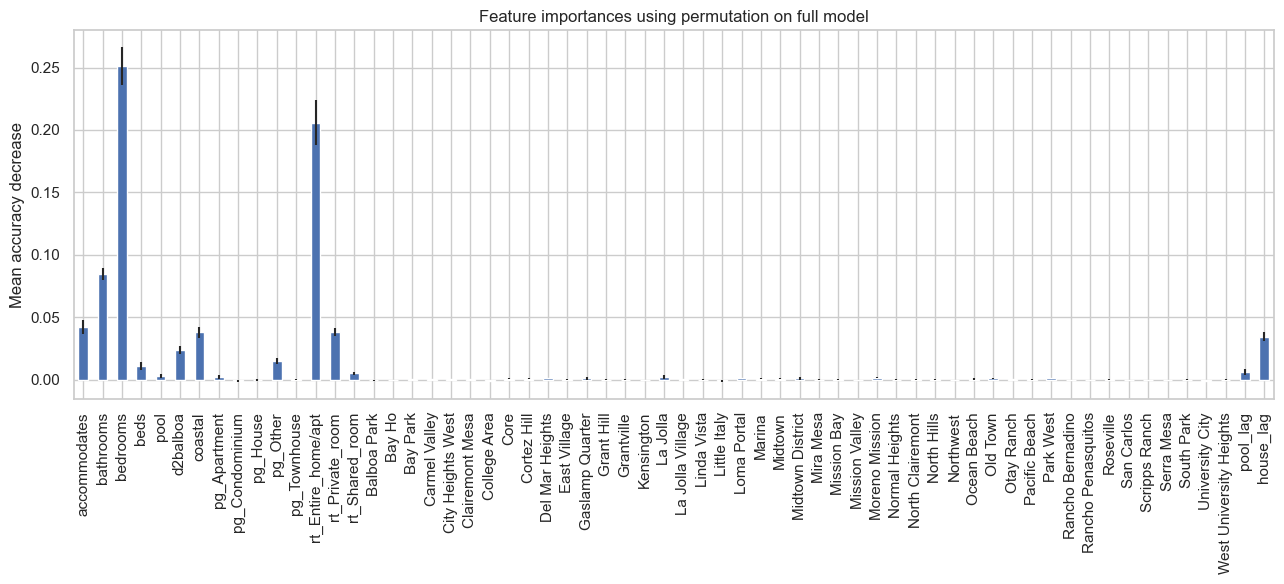

In [30]:
fig, ax = plt.subplots(figsize=(13,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Q.1 Feature Importances 
Tune the hyperparameters on your model and measure the feature importances using the impurity and permutation based feature importances. Did your importances change? (5 pts)

In [39]:
estimator_num = np.linspace(10, 200, 10).astype(int)
estimator_num

array([ 10,  31,  52,  73,  94, 115, 136, 157, 178, 200])

n_estimators: 10
---------------------------------
[0.69101515 0.69427278 0.66613189 0.67682533 0.68633874]
0.6829167791802007
R^2 is: 0.6709010546447893
Mean absolute error is: 0.33033653601864316
Mean squared error is: 0.2102797912651181


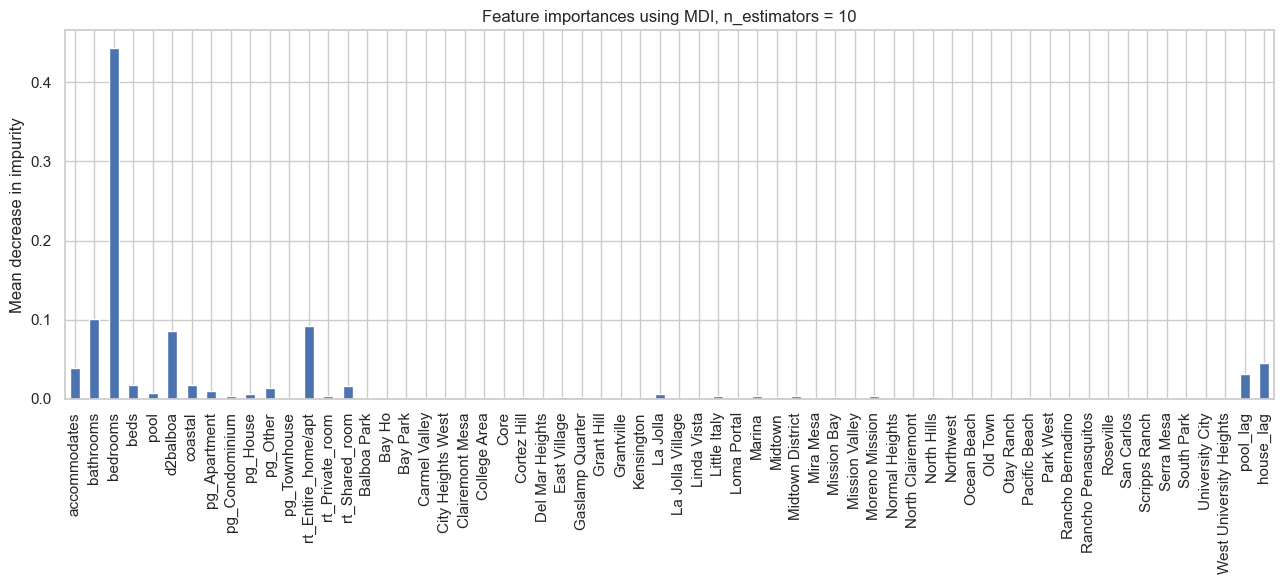

n_estimators: 31
---------------------------------
[0.70056545 0.71133919 0.68339459 0.69039528 0.70134277]
0.6974074560561754
R^2 is: 0.6881985230589741
Mean absolute error is: 0.3251386173424733
Mean squared error is: 0.1992274676436496


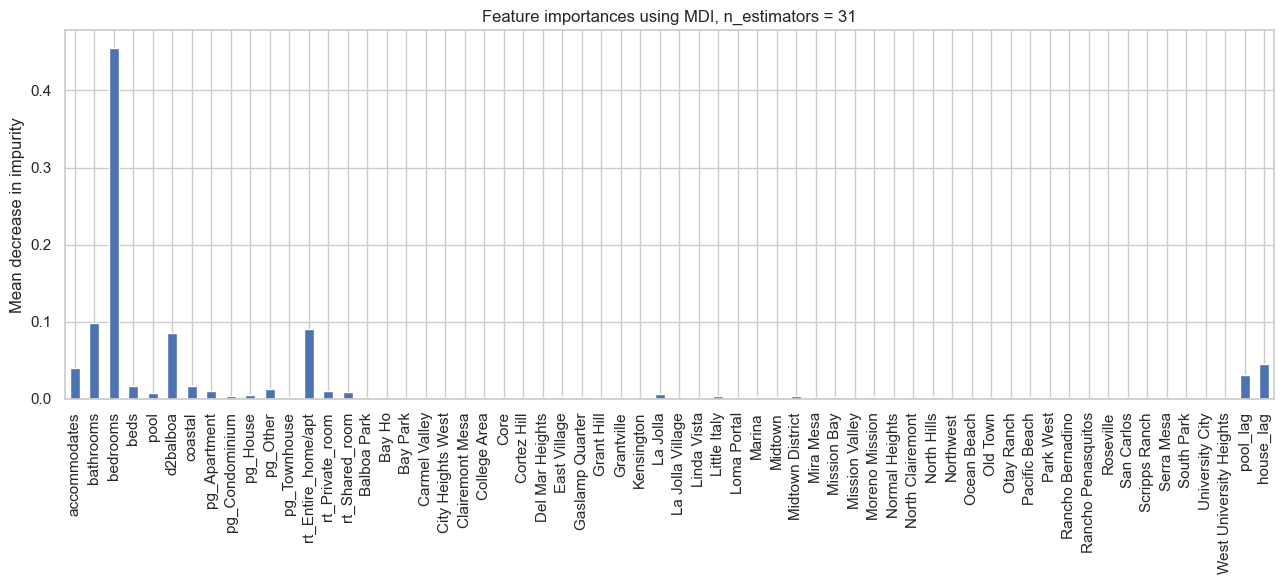

n_estimators: 52
---------------------------------
[0.70341533 0.714815   0.69276506 0.69446588 0.70193033]
0.7014783225814092
R^2 is: 0.6919337686777036
Mean absolute error is: 0.3223866075671455
Mean squared error is: 0.19684080952725053


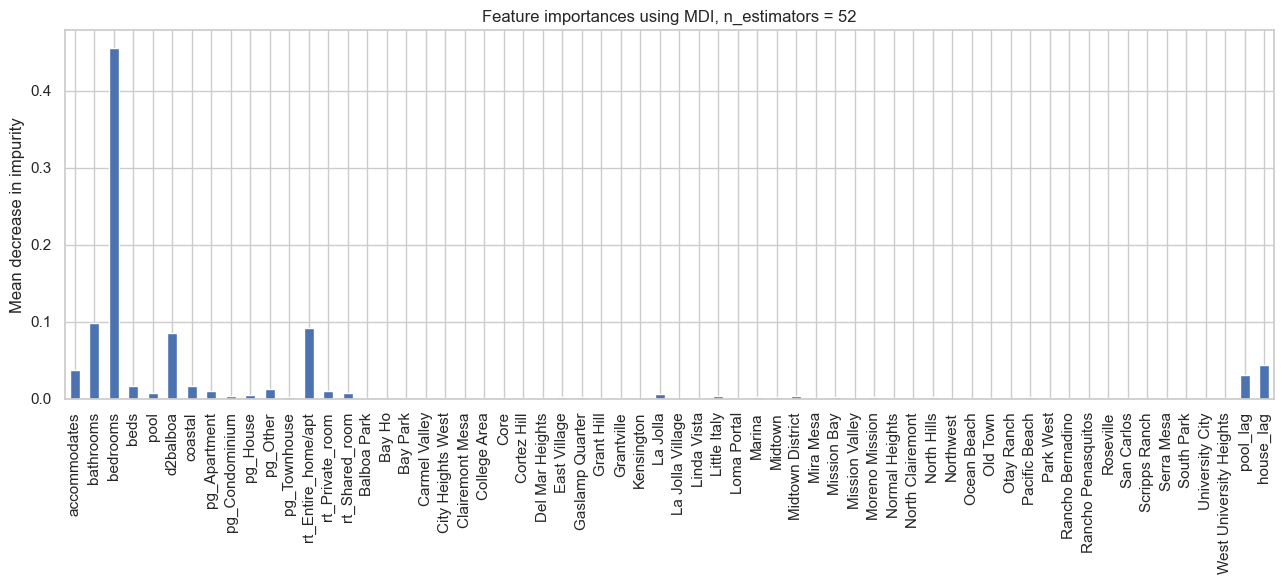

n_estimators: 73
---------------------------------
[0.70344359 0.71678766 0.69237865 0.69551637 0.70048739]
0.7017227319474524
R^2 is: 0.6912008333495865
Mean absolute error is: 0.3231244774042103
Mean squared error is: 0.19730912305417775


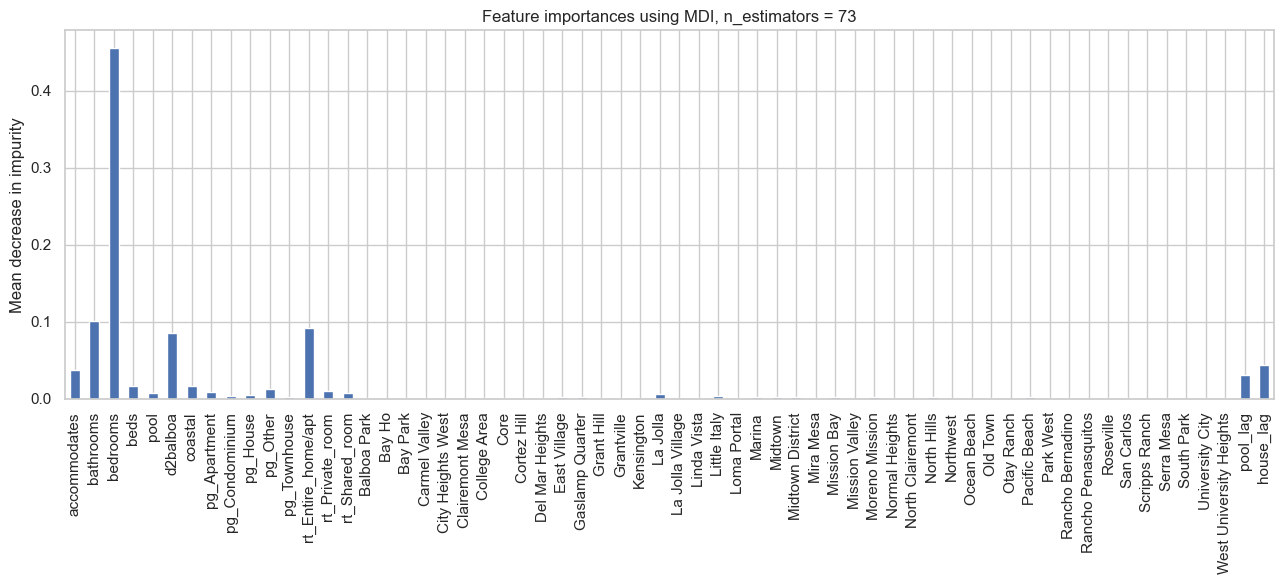

n_estimators: 94
---------------------------------
[0.70326211 0.71820079 0.69349529 0.69729742 0.69846306]
0.7021437323722955
R^2 is: 0.6903012279443766
Mean absolute error is: 0.3236461009203341
Mean squared error is: 0.19788393144994548


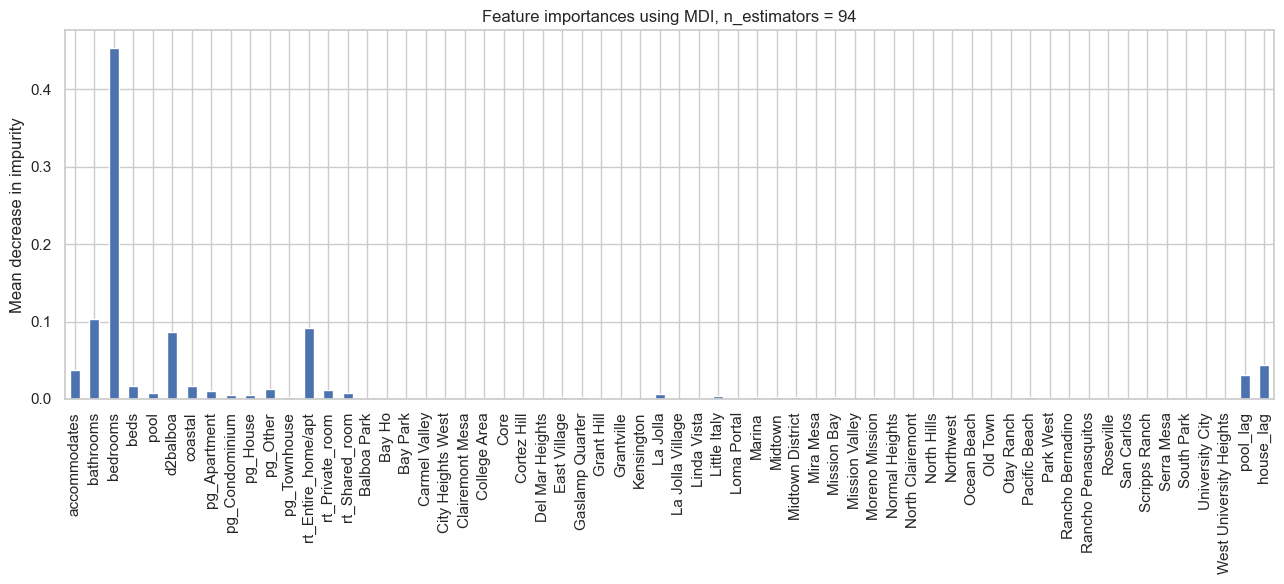

n_estimators: 115
---------------------------------
[0.70326443 0.71747168 0.69436228 0.69810448 0.69895731]
0.7024320353224744
R^2 is: 0.6906075202645565
Mean absolute error is: 0.32369938336008924
Mean squared error is: 0.19768822409183165


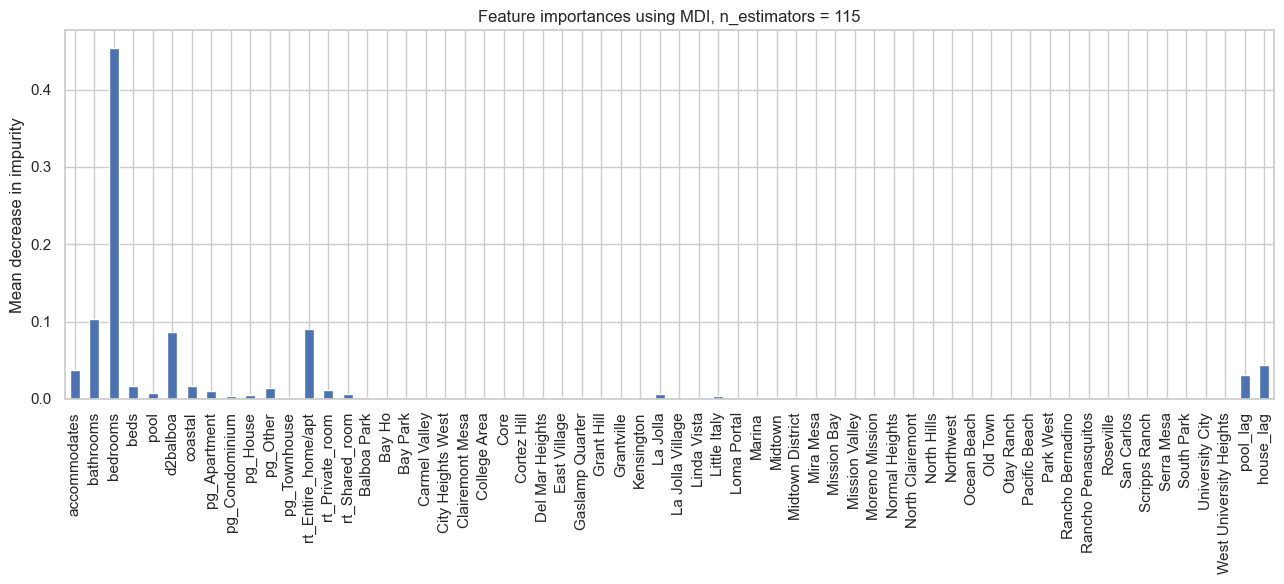

n_estimators: 136
---------------------------------
[0.70250441 0.71833042 0.69504592 0.69759939 0.69908389]
0.7025128052304168
R^2 is: 0.6901442710252338
Mean absolute error is: 0.32411338824524877
Mean squared error is: 0.19798422003689112


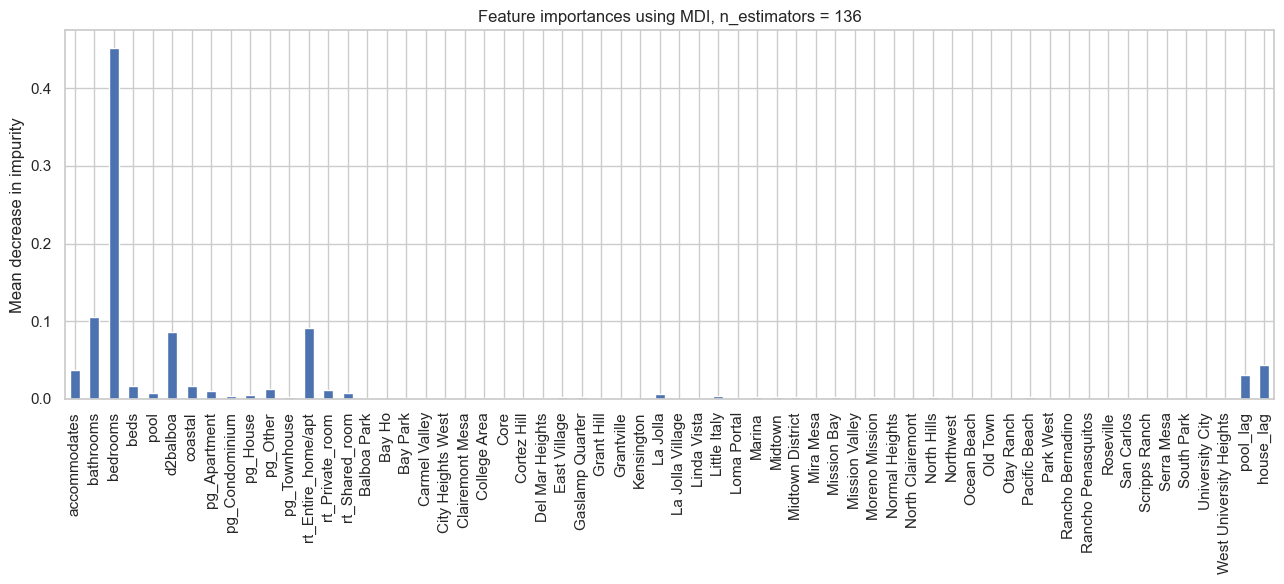

n_estimators: 157
---------------------------------
[0.70274516 0.71890861 0.69502286 0.69683974 0.6981755 ]
0.7023383750701616
R^2 is: 0.6909085489910918
Mean absolute error is: 0.3237894745243709
Mean squared error is: 0.19749587993918677


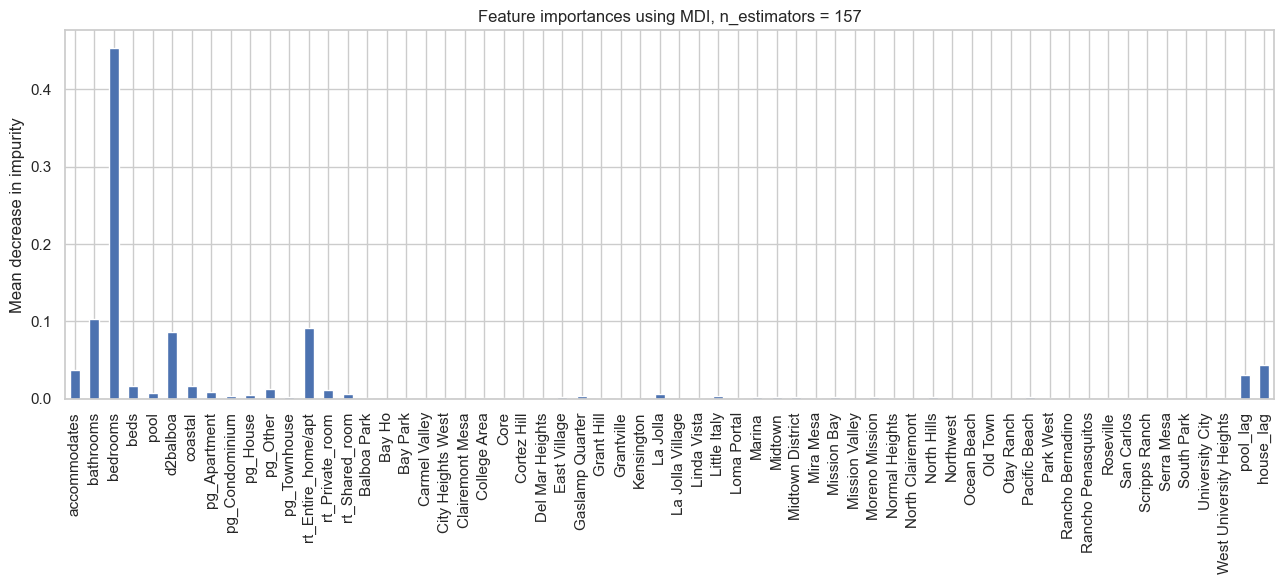

n_estimators: 178
---------------------------------
[0.70322779 0.71854869 0.69376105 0.69667222 0.69924933]
0.7022918167653295
R^2 is: 0.6919420971805549
Mean absolute error is: 0.3234748920951693
Mean squared error is: 0.1968354879792303


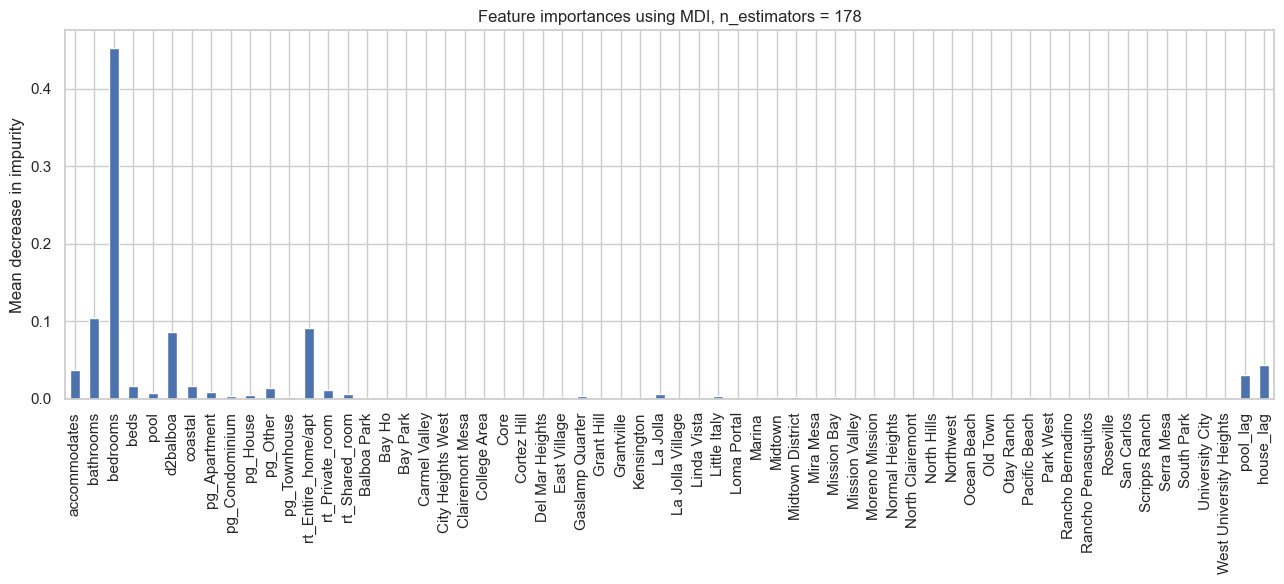

n_estimators: 200
---------------------------------
[0.70344954 0.71921723 0.69437271 0.69763975 0.69946537]
0.7028289194635746
R^2 is: 0.6922072319145124
Mean absolute error is: 0.3234762756051559
Mean squared error is: 0.19666607851347362


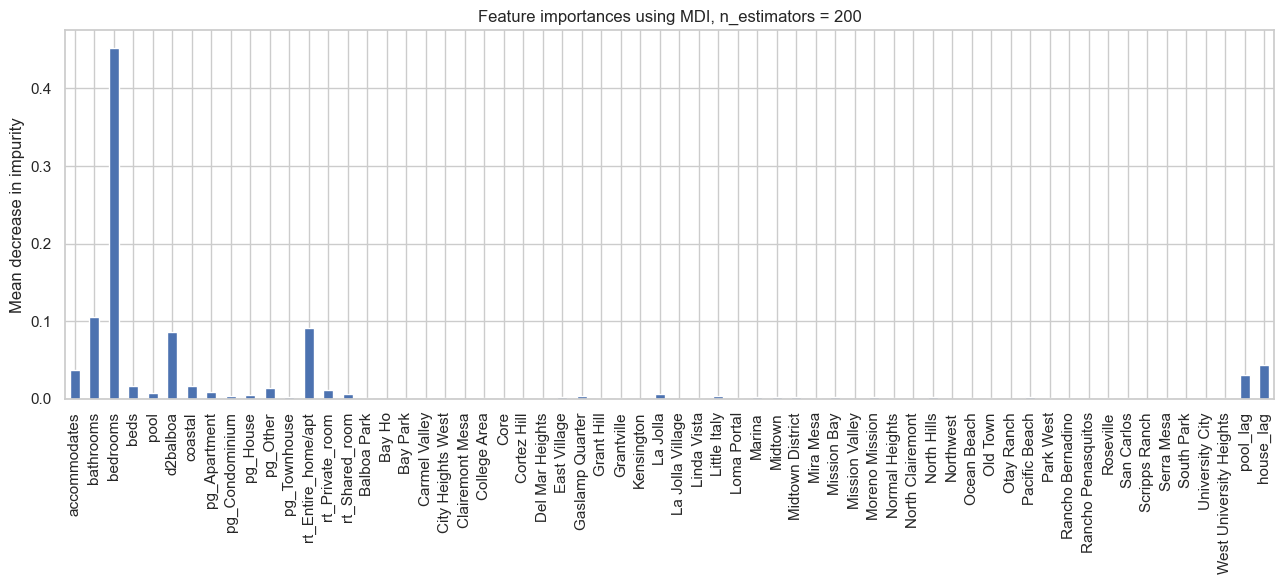

In [40]:
# lets tune random forest here
from sklearn.ensemble import RandomForestRegressor
for num in estimator_num:
    model = RandomForestRegressor(n_estimators=num, random_state=913)
    model.fit(X_train, y_train)

    print("n_estimators:", num)
    print('---------------------------------')

    # cross validation and score
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(scores)
    print(scores.mean())

    # test score
    ypred_rf = model.predict(X_test)
    print("R^2 is:", r2_score(y_test, ypred_rf))
    print("Mean absolute error is:", mean_absolute_error(y_test, ypred_rf))
    print("Mean squared error is:", mean_squared_error(y_test, ypred_rf))

    # impurity based feature importance
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=X.columns)

    fig, ax = plt.subplots(figsize=(13,6))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI, n_estimators = " + str(num))
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()


Answer: There is no significant change in the feature importance when "n_estimator" changes. When "n_estimator" increases, the model becomes more accurate, but not significant. More number of trees can help the model to be slightly more accurate, but it will also significantly increase the computational cost.